In [1]:
import pandas as pd
import numpy as np
from math import log
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm

In [13]:
#对pred_label进行标准化，用于计算熵值
def normalize_label(row):
    label = str(row["pred_label"]).strip()
    benchmark = row["benchmark"]

    if benchmark == "ethics":
        return label if label in ["0", "1"] else "invalid"
    elif benchmark == "mmlupro":
        return label if label in list("ABCDEFGHIJ") else "invalid"
    else:
        return "invalid" 
    
#计算熵值
def compute_normalized_entropy(labels):
    value_counts = pd.Series(labels).value_counts(normalize=True)
    entropy = -np.sum(value_counts * np.log(value_counts + 1e-10))  
    max_entropy = log(5)  
    return entropy / max_entropy if max_entropy > 0 else 0

#计算joingt probability
def is_all_equal(labels):
    unique_labels = set(labels)
    return 1 if len(unique_labels) == 1 else 0

In [3]:
columns_to_keep = [
    "benchmark", "is_correct", "model", "pred_label", "ground_truth", 
    "prompt_lang", "question_lang", "prompt_id", "question_id", "output_len"
]

In [14]:
#RQ1函数，输入一个df，输出一个计算好4个metric的df
def compute_metrics(df):
    df_len_var_step1 = (
        df
        .groupby(["benchmark", "prompt_id", "model", "question_id"])
        .agg(output_len_var=("output_len", "var"))
        .reset_index()
    )

    df_len_var = (
        df_len_var_step1
        .groupby(["benchmark", "model", "prompt_id"])
        .agg(output_tokens_var=("output_len_var", "mean"))
        .reset_index()
    )

    df_acc_var_len = (
        df
        .groupby(["benchmark", "prompt_id", "question_lang", "model"])
        .mean(numeric_only=True)
        .reset_index()
        .groupby(["benchmark", "model", "prompt_id"])
        .agg(
            acc_mean=("is_correct", "mean"),
            acc_var=("is_correct", "var"),
        )
        .reset_index()
    )
    df_consistency = (
        df
        .groupby(["benchmark", "model", "prompt_id", "question_id"])["pred_label"]
        .apply(is_all_equal)
        .reset_index(name="all_equal_consistency")
        .groupby(["benchmark", "model", "prompt_id"])["all_equal_consistency"]
        .mean()
        .reset_index(name="consistency")
    )

    df_merged = pd.merge(df_acc_var_len, df_consistency, on=["benchmark", "model", "prompt_id"], how="left")
    df_merged = pd.merge(df_merged, df_len_var, on=["benchmark", "model", "prompt_id"], how="left")
    return df_merged

In [15]:
#RQ1-1数据处理
file_path = "/shared/4/projects/llm-personas/tmp/experiment1_simple.jsonl"
df_exp1_1 = pd.read_json(file_path, lines=True)
df_exp1_1 = df_exp1_1[df_exp1_1["benchmark"].isin(["math500"])]
df_exp1_1_samelang = df_exp1_1[df_exp1_1["prompt_lang"] == df_exp1_1["question_lang"]]
df_exp1_1_crosslang = df_exp1_1[df_exp1_1["prompt_lang"] == "en"]
exp1_samelang_metric = compute_metrics(df_exp1_1_samelang)
exp1_crosslang_metric = compute_metrics(df_exp1_1_crosslang)
exp1_samelang_metric = compute_metrics(df_exp1_1_samelang)
exp1_crosslang_metric = compute_metrics(df_exp1_1_crosslang)

/tmp/ipykernel_925614/1568714577.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=plot_data, x="metric", y="value", hue="label", ax=ax, palette=palette)
/tmp/ipykernel_925614/1568714577.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=plot_data, x="metric", y="value", hue="label", ax=ax, palette=palette)
/tmp/ipykernel_925614/1568714577.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=plot_data, x="metric", y="value", hue="label", ax=ax, palette=palette)
/tmp/ipykernel_925614/1568714577.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=plot_data, x="metric", y="value", hue="label", ax=ax, palette=palette)


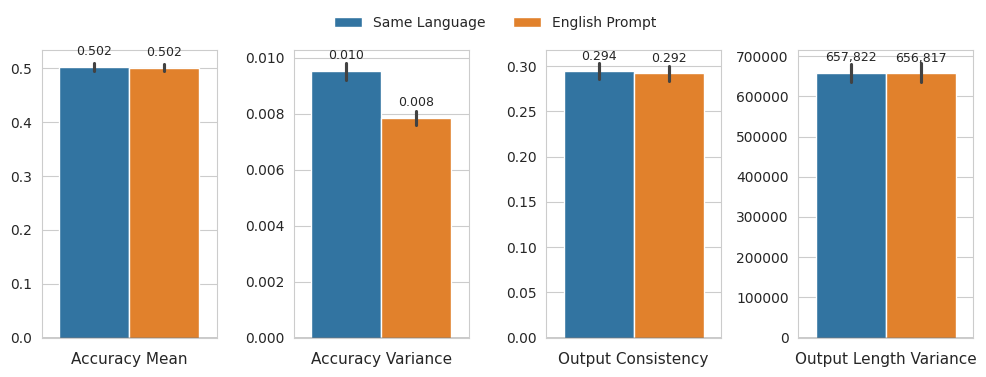

In [16]:
#RQ1-1画图
def plot_grouped_metrics_final(df1, df2, label1="Same Language", label2="English Prompt"):
    sns.set_style("whitegrid")

    metrics = ["acc_mean", "acc_var", "consistency", "output_tokens_var"]
    metric_labels = {
        "acc_mean": "Accuracy Mean",
        "acc_var": "Accuracy Variance",
        "consistency": "Output Consistency",
        "output_tokens_var": "Output Length Variance"
    }

    df1_long = df1[metrics].melt(var_name="metric", value_name="value")
    df1_long["label"] = label1

    df2_long = df2[metrics].melt(var_name="metric", value_name="value")
    df2_long["label"] = label2

    df_plot = pd.concat([df1_long, df2_long], ignore_index=True)
    fig, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=False)
    palette = sns.color_palette("tab10")

    for i, metric in enumerate(metrics):
        ax = axes[i]
        plot_data = df_plot[df_plot["metric"] == metric]
        
        sns.barplot(data=plot_data, x="metric", y="value", hue="label", ax=ax, palette=palette)

        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title('', pad=10)
        ax.text(0.5, -0.05, metric_labels[metric], ha='center', va='top',
                transform=ax.transAxes, fontsize=11)

        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                xpos = bar.get_x() + bar.get_width() / 2
                ymax = ax.get_ylim()[1]
                label = f"{int(height):,}" if height >= 10000 else f"{height:.3f}"
                ax.text(xpos, height + 0.03 * ymax, label, ha='center', va='bottom', fontsize=9)

        ax.axhline(0, color='black', linewidth=1)

        ax.get_legend().remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.95))

    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()
plot_grouped_metrics_final(exp1_samelang_metric, exp1_crosslang_metric, label1="Same Language", label2="English Prompt")

In [18]:
#RQ1-2数据处理
file_path = "/shared/4/projects/llm-personas/tmp/experiment1_simple.jsonl"
df_exp1_2 = pd.read_json(file_path, lines=True)
df_exp1_2_samelang = df_exp1_2[df_exp1_2["prompt_lang"] == df_exp1_2["question_lang"]]
df_exp1_2_crosslang = df_exp1_2[df_exp1_2["prompt_lang"] == "en"]
exp1_2_samelang_metric = compute_metrics(df_exp1_2_samelang)
exp1_2_metric = exp1_2_samelang_metric.groupby(["model", "prompt_id"])[["acc_mean", "acc_var", "consistency", "output_tokens_var"]].mean().reset_index()

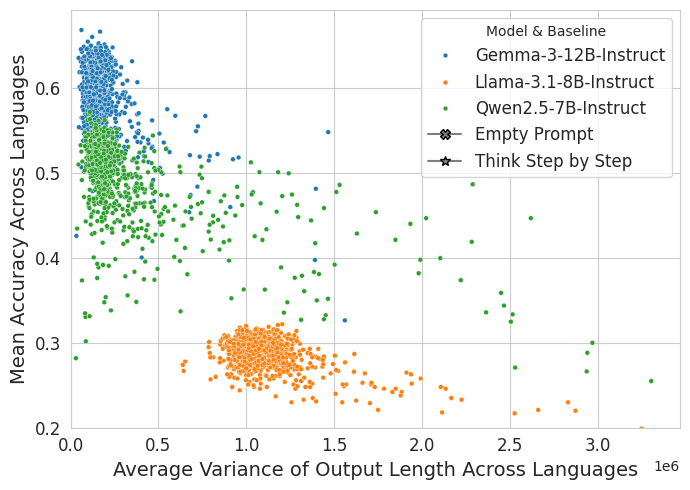

In [20]:
#RQ1-2画图
#绘制metric的散点图结果
# target_benchmark = "math500"
# data = samelang_metric[samelang_metric["benchmark"] == target_benchmark]
data = exp1_2_metric
# baseline = df_baseline[df_baseline["benchmark"] == target_benchmark]
value_list = ["acc_mean", "acc_var", "consistency", "output_tokens_var"]
label_list = ["Mean Accuracy Across Languages", "Variance of Accuracy Across Languages", "Consistency of Model Output Across Language", "Average Variance of Output Length Across Languages"]
variable_1 = 3
variable_2 = 0
x_value = value_list[variable_1]
y_value = value_list[variable_2]
x_label = label_list[variable_1]
y_label = label_list[variable_2]
palette = sns.color_palette("tab10")
model_palette = dict(zip(data["model"].unique(), palette))
baseline_markers = {
    "p_1000": "X",  
    "p_1001": "*",  
}
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=data ,
    x=x_value,
    y=y_value,
    hue="model",
    s=12,
    palette=model_palette,
    legend=True
)
# for prompt_id, marker in baseline_markers.items():
#     baseline_subset = baseline[baseline["prompt_id"] == prompt_id]
#     for _, row in baseline_subset.iterrows():
#         model_color = model_palette.get(row["model"], "gray")
#         plt.scatter(
#             row[x_value],
#             row[y_value],
#             s=70,
#             color=model_color,         
#             edgecolors="black",
#             linewidths=1,
#             marker=marker,
#             label=None                    
#         )
custom_legend = [
    Line2D([0], [0], marker="X", color="gray", label="Empty Prompt",
           markerfacecolor="gray", markersize=7, markeredgecolor="black"),
    Line2D([0], [0], marker="*", color="gray", label="Think Step by Step",
           markerfacecolor="gray", markersize=7, markeredgecolor="black"),
]
plt.legend(title="Model & Baseline",
           handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, fontsize=12)
plt.xlabel(x_label, fontsize=14)
plt.ylabel(y_label, fontsize=14)
# plt.title(f"System Prompt Steerability on {target_benchmark}", fontsize=16)
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

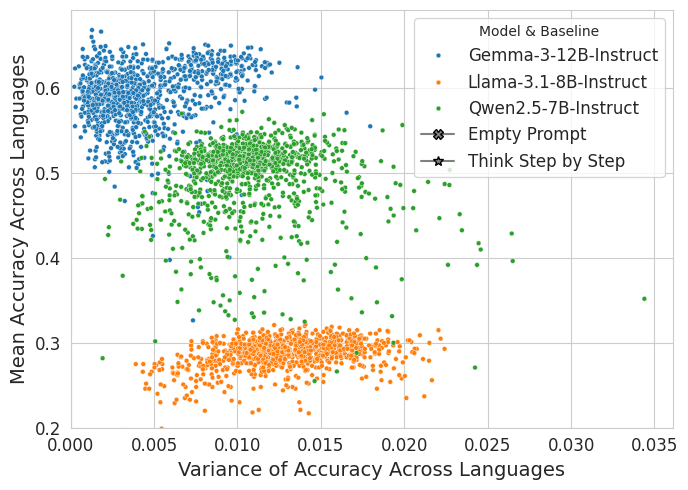

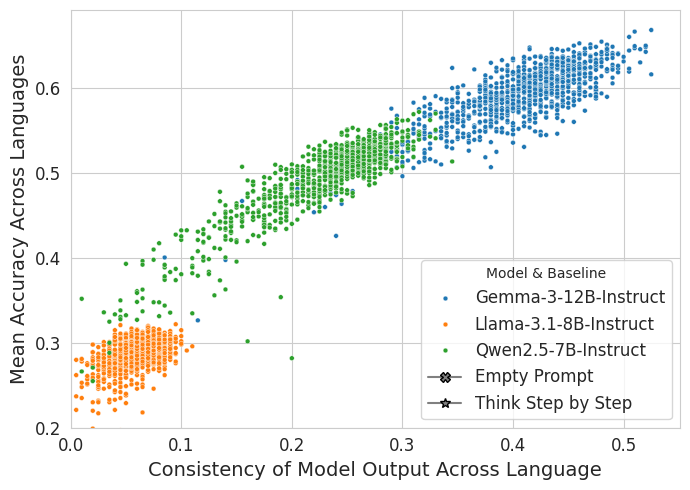

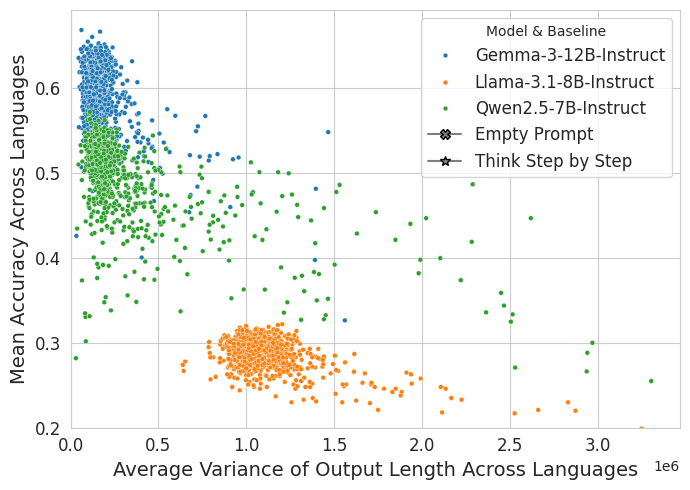

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 数据
data = exp1_2_metric

# 值和标签列表
value_list = ["acc_mean", "acc_var", "consistency", "output_tokens_var"]
label_list = [
    "Mean Accuracy Across Languages",
    "Variance of Accuracy Across Languages",
    "Consistency of Model Output Across Language",
    "Average Variance of Output Length Across Languages"
]

# 固定 y 为 acc_mean（value_list[0]）
y_value = value_list[0]
y_label = label_list[0]

# 设置颜色
palette = sns.color_palette("tab10")
model_palette = dict(zip(data["model"].unique(), palette))

# 遍历 x = 1,2,3
for variable_1 in [1, 2, 3]:
    x_value = value_list[variable_1]
    x_label = label_list[variable_1]

    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=data,
        x=x_value,
        y=y_value,
        hue="model",
        s=12,
        palette=model_palette,
        legend=True
    )

    # 添加自定义 legend
    custom_legend = [
        Line2D([0], [0], marker="X", color="gray", label="Empty Prompt",
               markerfacecolor="gray", markersize=7, markeredgecolor="black"),
        Line2D([0], [0], marker="*", color="gray", label="Think Step by Step",
               markerfacecolor="gray", markersize=7, markeredgecolor="black"),
    ]
    plt.legend(title="Model & Baseline",
               handles=plt.gca().get_legend_handles_labels()[0] + custom_legend,
               fontsize=12)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.grid(True)
    plt.xlim(left=0)
    plt.ylim(bottom=0.2)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    # 保存每张图
    plt.savefig(f"scatter_{x_value}_vs_{y_value}.png", dpi=300)
    plt.show()


In [22]:
#RQ1-3数据处理
file_path = "/shared/4/projects/llm-personas/tmp/experiment1_simple.jsonl"
sys_prompt_df = pd.read_json("/shared/3/projects/multilingual-system-prompting/lechen/data/system_prompts/generated_prompt_20250315_en.jsonl", lines=True)
sys_prompt_df["prompt_id"] = np.array(range(len(sys_prompt_df)))
sys_prompt_df["prompt_id"] = sys_prompt_df["prompt_id"].apply(lambda x: "p_"+str(x))
df_exp1_3 = pd.read_json(file_path, lines=True)

#这一行之后等数据全了要去掉
df_exp1_3 = df_exp1_3[df_exp1_3["benchmark"]=="math500"]

df_exp1_3_samelang = df_exp1_3[df_exp1_3["prompt_lang"] == df_exp1_3["question_lang"]]
df_exp1_3_crosslang = df_exp1_3[df_exp1_3["prompt_lang"] == "en"]
exp1_3_samelang_metric = compute_metrics(df_exp1_3_samelang)
exp1_3_crosslang_metric = compute_metrics(df_exp1_3_crosslang)
exp1_3_samelang_metric["is_cross_language"] = 0
exp1_3_crosslang_metric["is_cross_language"] = 1
exp1_3_combined_metric = pd.concat([exp1_3_samelang_metric, exp1_3_crosslang_metric], ignore_index=True)
exp1_3_combined_metric_final = exp1_3_combined_metric.groupby(["prompt_id", "is_cross_language"], as_index=False).mean(numeric_only=True)
exp1_3_combined_metric_final = exp1_3_combined_metric_final.merge(sys_prompt_df, on="prompt_id")


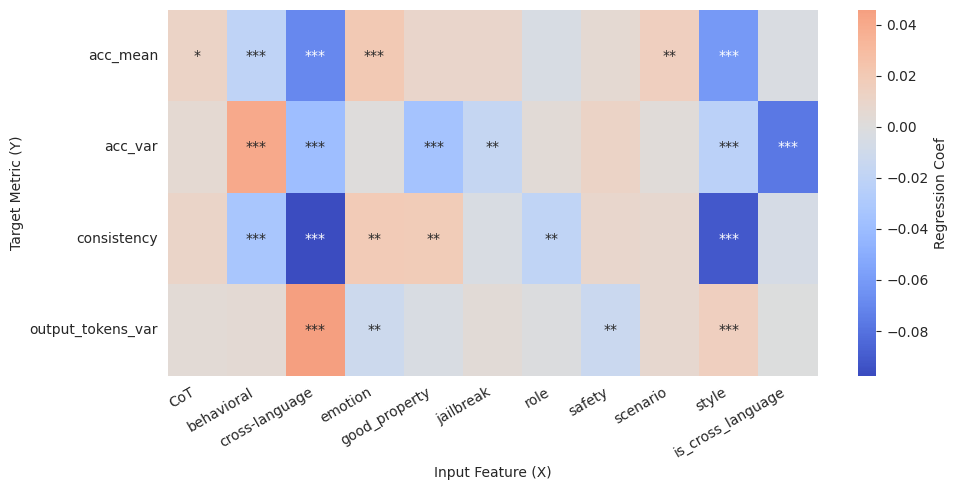

In [23]:
#RQ1-3-1画图
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt

def plot_regression_heatmap_transposed(df_with_prompt, target_list=["acc_mean", "acc_var", "consistence", "output_tokens_var"]):

    mlb = MultiLabelBinarizer()
    df = df_with_prompt.copy()
    X_cat_all = pd.DataFrame(mlb.fit_transform(df["category"]), columns=mlb.classes_)
    df_encoded = pd.concat([df.drop(columns="category").reset_index(drop=True), X_cat_all], axis=1)

    all_components = mlb.classes_.tolist() + ["is_cross_language"]
    rows = []

    for target in target_list:
        y_raw = df_encoded[target]
        y = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

        X = df_encoded[all_components]
        X = X.loc[:, X.sum() > 0]
        X_with_const = sm.add_constant(X)
        model_fit = sm.OLS(y, X_with_const).fit()

        for comp in X.columns:
            coef = model_fit.params.get(comp, float('nan'))
            pval = model_fit.pvalues.get(comp, float('nan'))
            rows.append({
                "target": target,
                "component": comp,
                "coef": coef,
                "pval": pval
            })

    result_df = pd.DataFrame(rows)

    def get_significance_marker(p):
        if p < 0.001: return '***'
        elif p < 0.01: return '**'
        elif p < 0.05: return '*'
        else: return ''

    result_df['annot'] = result_df['pval'].map(get_significance_marker)

    coef_matrix = result_df.pivot(index='target', columns='component', values='coef')
    annot_matrix = result_df.pivot(index='target', columns='component', values='annot')

    coef_matrix = coef_matrix.reindex(target_list)
    annot_matrix = annot_matrix.reindex(target_list)

    cols = coef_matrix.columns.tolist()
    if "is_cross_language" in cols:
        cols = [c for c in cols if c != "is_cross_language"] + ["is_cross_language"]
        coef_matrix = coef_matrix.reindex(columns=cols)
        annot_matrix = annot_matrix.reindex(columns=cols)

    plt.figure(figsize=(10, 5))
    sns.heatmap(coef_matrix.astype(float), annot=annot_matrix, fmt="", cmap="coolwarm", center=0,
                cbar_kws={'label': 'Regression Coef'})
    plt.ylabel("Target Metric (Y)")
    plt.xlabel("Input Feature (X)")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

plot_regression_heatmap_transposed(
    exp1_3_combined_metric_final,
    target_list=["acc_mean", "acc_var", "consistency", "output_tokens_var"]
)
